# Project: Investigating Soccer Player Interceptions

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This project will check to see if soccer player interceptions have any type of relationship with a player’s preferred foot, player penalties, or a player’s age during a game. 

### Dataset

> The data for this project was obtained from a Udacity sqlite database (https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True).

> The Udacity database included a table called player_attributes where I was able to obtain values for player interceptions, player's preferred foot, and player penalties. Another table called player was also combine with the player_attributes dataset to add the additional value of birthday. Birthday was used to calculate the player's age during the game.

In [86]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

import sqlite3
import pandas as pd
import numpy as np
% matplotlib inline


<a id='wrangling'></a>
## Data Wrangling

> The first step in this project is to gather and review the data. 

> The data was provided to me from Udacity in a sqlite database. I used the database to generate a python panda DataFrame.

In [87]:
# Connect to the soccer database
conn = sqlite3.connect("database.sqlite")

# Read database and save as panda DataFrame
df = pd.read_sql_query("""SELECT player_attributes.player_fifa_api_id,
                                 player_attributes.date,
                                 player_attributes.preferred_foot,
                                 player_attributes.penalties,
                                 player_attributes.interceptions,
                                 player.birthday
                          FROM player_attributes
                          JOIN player ON player_attributes.player_fifa_api_id = player.player_fifa_api_id""", conn)

print(df.head())

# We've got everything we need from the database so close the database connection
conn.close()

   player_fifa_api_id                 date preferred_foot  penalties  \
0              218353  2016-02-18 00:00:00          right       48.0   
1              218353  2015-11-19 00:00:00          right       48.0   
2              218353  2015-09-21 00:00:00          right       48.0   
3              218353  2015-03-20 00:00:00          right       47.0   
4              218353  2007-02-22 00:00:00          right       47.0   

   interceptions             birthday  
0           70.0  1992-02-29 00:00:00  
1           70.0  1992-02-29 00:00:00  
2           41.0  1992-02-29 00:00:00  
3           40.0  1992-02-29 00:00:00  
4           40.0  1992-02-29 00:00:00  


### Review the data
> Once the data was collected, I reviewed the dataset.

> The data had some null values.  These values accounted for less than 2% of the total dataset.  Since the missing values were not significant, I chose to remove the values. 

> The date column and birthday column were transformed from string values to date values.  Since birthday is not a changing number, birthday was used to instead calculate player age at the time of the game date.

> 126 duplicate rows were found in the database and removed from the dataset. 

In [88]:
# Check for missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183929 entries, 0 to 183928
Data columns (total 6 columns):
player_fifa_api_id    183929 non-null int64
date                  183929 non-null object
preferred_foot        183142 non-null object
penalties             183142 non-null float64
interceptions         183142 non-null float64
birthday              183929 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 8.4+ MB
None


In [89]:
# There are 183,929 columns in this data set.  
# It looks like preferred_foot, penalties, and interceptions have missing values.

# Let's take a look at which values are missing.
missing_values = df[df.isnull().any(axis=1)]
print(missing_values.head(100))

       player_fifa_api_id                 date preferred_foot  penalties  \
483                 33022  2007-02-22 00:00:00           None        NaN   
983                111085  2007-02-22 00:00:00           None        NaN   
1752               165740  2007-02-22 00:00:00           None        NaN   
2089               176941  2007-02-22 00:00:00           None        NaN   
2482               177615  2007-02-22 00:00:00           None        NaN   
2498               177713  2007-02-22 00:00:00           None        NaN   
2540                 2115  2007-02-22 00:00:00           None        NaN   
3283               152769  2007-02-22 00:00:00           None        NaN   
4006               172176  2007-02-22 00:00:00           None        NaN   
4202               140307  2007-02-22 00:00:00           None        NaN   
4593               110375  2007-02-22 00:00:00           None        NaN   
4801               178087  2007-02-22 00:00:00           None        NaN   
4998        

In [90]:
# It looks like games on 2/22/2007 have missing data. let's see how many dates in total are missing:
print(missing_values.groupby('date').nunique())

                     player_fifa_api_id  date  preferred_foot  penalties  \
date                                                                       
2007-02-22 00:00:00                 731     1               0          0   
2007-08-30 00:00:00                   1     1               0          0   
2008-08-30 00:00:00                   2     1               0          0   
2009-02-22 00:00:00                   1     1               0          0   
2009-08-30 00:00:00                   2     1               0          0   
2010-02-22 00:00:00                   2     1               0          0   
2010-08-30 00:00:00                   1     1               0          0   
2011-02-22 00:00:00                   1     1               0          0   
2011-08-30 00:00:00                   3     1               0          0   
2012-02-22 00:00:00                   1     1               0          0   
2012-08-31 00:00:00                   2     1               0          0   
2013-02-15 0

In [91]:
# The majority of missing values come from 2/22/2007.  There are also a few missing values on other dates.

# For this project, I am going to drop the null values. 
# Even with the dropped values, our dataset will have 183,142 values left for calcuation which is a large sample size. 
# Also, the missing values account for less than 2% of the original dataset and only one date will be lost.

df.dropna(inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183142 entries, 0 to 183928
Data columns (total 6 columns):
player_fifa_api_id    183142 non-null int64
date                  183142 non-null object
preferred_foot        183142 non-null object
penalties             183142 non-null float64
interceptions         183142 non-null float64
birthday              183142 non-null object
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ MB
None


In [92]:
# Incorrect Datatypes

# I'm going to change date fields from strings to dates for better data manipulation. 
df['date'] = pd.to_datetime(df['date'])
df['birthday'] = pd.to_datetime(df['birthday'])

# Birthday isn't super useful.  What I really want is the player's age during the game
# Stack Overflow helped with the calcuation
df['age_during_game'] =  (df['date'] - df['birthday']).apply(lambda age_in_days: int(float(age_in_days.days)/365))

print(df.head(5))

   player_fifa_api_id       date preferred_foot  penalties  interceptions  \
0              218353 2016-02-18          right       48.0           70.0   
1              218353 2015-11-19          right       48.0           70.0   
2              218353 2015-09-21          right       48.0           41.0   
3              218353 2015-03-20          right       47.0           40.0   
4              218353 2007-02-22          right       47.0           40.0   

    birthday  age_during_game  
0 1992-02-29               23  
1 1992-02-29               23  
2 1992-02-29               23  
3 1992-02-29               23  
4 1992-02-29               14  


In [93]:
# let's check player_fifa_api_id and date.  Ideally, one player should only have one set of score per game
print(df.groupby(['player_fifa_api_id', 'date']).count().max())

preferred_foot     2
penalties          2
interceptions      2
birthday           2
age_during_game    2
dtype: int64


In [94]:
#  It looks like we have some duplicates in our system.  Let's check and make sure they are full duplicates.

print(df[df.duplicated()].info()) # 126 full diplucates

print()

print(df[df.duplicated(['player_fifa_api_id', 'date'])].info()) # 126 ['player_fifa_api_id', 'date'] duplicates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 7447 to 161452
Data columns (total 7 columns):
player_fifa_api_id    126 non-null int64
date                  126 non-null datetime64[ns]
preferred_foot        126 non-null object
penalties             126 non-null float64
interceptions         126 non-null float64
birthday              126 non-null datetime64[ns]
age_during_game       126 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 7.9+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 7447 to 161452
Data columns (total 7 columns):
player_fifa_api_id    126 non-null int64
date                  126 non-null datetime64[ns]
preferred_foot        126 non-null object
penalties             126 non-null float64
interceptions         126 non-null float64
birthday              126 non-null datetime64[ns]
age_during_game       126 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 

In [95]:
# Since they are full duplicates, I am going to drop the duplicate values. 
df.drop_duplicates(inplace=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183016 entries, 0 to 183928
Data columns (total 7 columns):
player_fifa_api_id    183016 non-null int64
date                  183016 non-null datetime64[ns]
preferred_foot        183016 non-null object
penalties             183016 non-null float64
interceptions         183016 non-null float64
birthday              183016 non-null datetime64[ns]
age_during_game       183016 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 11.2+ MB
None


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Review Interception Data

AxesSubplot(0.125,0.125;0.775x0.755)


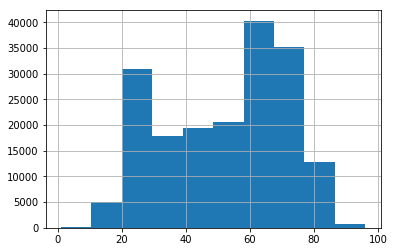

In [111]:
print(df['interceptions'].hist())

### Review Preferred Foot

AxesSubplot(0.125,0.125;0.775x0.755)


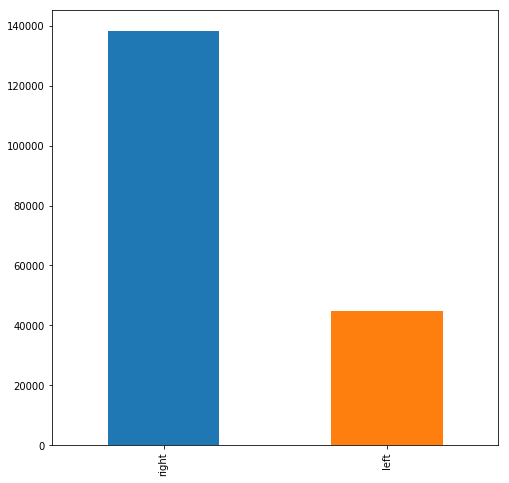

In [110]:
print(df['preferred_foot'].value_counts().plot(kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)


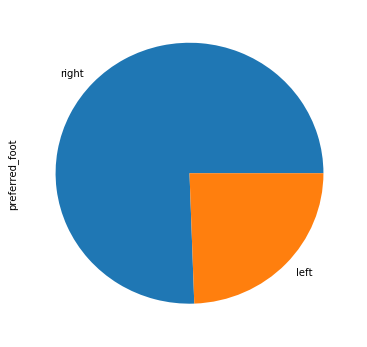

In [114]:
print(df['preferred_foot'].value_counts().plot(kind='pie', figsize=(6, 6)))

### Review Penalties

AxesSubplot(0.125,0.125;0.775x0.755)


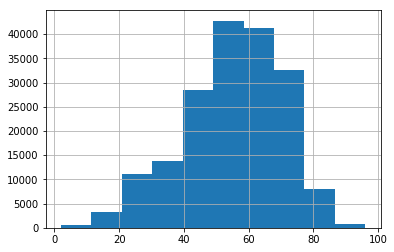

In [115]:
print(df['penalties'].hist())

### Review Age During Game

AxesSubplot(0.125,0.125;0.775x0.755)


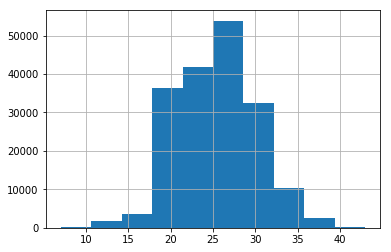

In [116]:
print(df['age_during_game'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


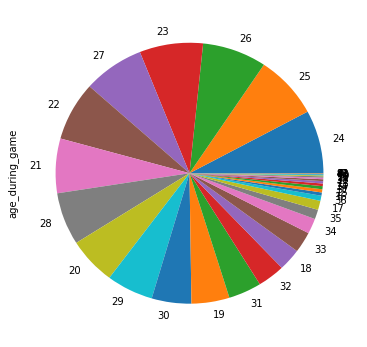

In [117]:
print(df['age_during_game'].value_counts().plot(kind='pie', figsize=(6, 6)))

### Research Question 1 (Replace this header name!)

In [ ]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


### Research Question 2  (Replace this header name!)

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])